# Embeddings visualization
## For this notebook you need:
> Images with .img resolution should be in the 'data' folder

> Need weight model for autoencoder | [download](https://marsanomalies-wcy6910.slack.com/archives/CHBG8KMQB/p1555569567023700?thread_ts=1555569252.022600&cid=CHBG8KMQB)

> After launching the entire laptop, the **'logs_embeddings'** folder will be created.

> To start Tensorboard run the command **tensorboard --logdir=path/to/logs_embeddings**

> After that in the address bar of the browser you need to type: _http://localhost:6006_

In [1]:
from extract_patches import extract_patches_from_img
from models.convautoencoderv1 import ConvAutoencoderV1
import torch
import torch.nn as nn
from torchsummary import summary
from pytorch_utils import *

import os
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import cv2
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector

% matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    

class ConvAutoencoderV2(nn.Module):
    def __init__(self, image_channels=1):
        super(ConvAutoencoderV2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 5, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(5, 10, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(10, 15, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(15, 20, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            nn.Conv2d(20, 25, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            
            Flatten(),
        )

    def forward(self, x):
        x = self.encoder(x)        
        return x

summary(ConvAutoencoderV2().to(device), (1, 256, 256))


class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=20, H=16, W=16):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 128, 128]             130
         LeakyReLU-2          [-1, 5, 128, 128]               0
            Conv2d-3           [-1, 10, 64, 64]           1,260
         LeakyReLU-4           [-1, 10, 64, 64]               0
            Conv2d-5           [-1, 15, 32, 32]           3,765
         LeakyReLU-6           [-1, 15, 32, 32]               0
            Conv2d-7           [-1, 20, 16, 16]           7,520
         LeakyReLU-8           [-1, 20, 16, 16]               0
            Conv2d-9             [-1, 25, 8, 8]          12,525
        LeakyReLU-10             [-1, 25, 8, 8]               0
          Flatten-11                 [-1, 1600]               0
Total params: 25,200
Trainable params: 25,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/ba

## Load in our autoencoder weights

In [3]:
model = ConvAutoencoderV2(1)

In [4]:
# path to the weight model
weight_mod = 'model_v2_e_1999 (1).pth'

In [5]:
pretrained_weights = torch.load(weight_mod, map_location='cpu')

model_weights = model.state_dict()

#Cut off weigth of decoder
pretrained_weights = {k: v for k, v in pretrained_weights.items() if k in model_weights}

#Load weights of encoder
model_weights.update(pretrained_weights) 

model.load_state_dict(pretrained_weights)
model.eval()

ConvAutoencoderV2(
  (encoder): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(5, 10, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(10, 15, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(15, 20, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(20, 25, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Flatten()
  )
)

In [6]:
def predict(images):
    model.eval()
    test_data = images
    test_data = test_data.to(device)

    # forward
    test_output = model(test_data)
    
    return test_output.data.cpu().numpy()

In [7]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """

    data = data.astype(np.float32)
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='minimum')
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

### Images must be in folder "data"

In [25]:
PATH = os.getcwd()
if not os.path.exists('logs_embeddings'):
    os.mkdir('logs_embeddings')
LOG_DIR = PATH + '/logs_embeddings'

In [26]:
LOG_DIR

'/home/artem/mars/mars-anomalies-aae/logs_embeddings'

In [27]:
img  = 'ESP_011261_1960_BG12_0.IMG'
img2 = 'ESP_011261_1960_BG12_1.IMG'
img3 = 'ESP_011261_1960_BG13_0.IMG'

images , ids  = extract_patches_from_img(img, 256)
images2, ids2 = extract_patches_from_img(img2, 256) 
images3, ids3 = extract_patches_from_img(img3, 256)

In [28]:
for i in range(len(images2)):
    images.append(images2[i])
    ids.append(ids2[i])
    
print('Images + images2: ', len(images), "\nWe need {} more".format(1000-len(images)))

for i in range(1000-len(images)):
    images.append(images3[i])
    ids.append(ids3[i])
    
num_images = len(images)
print(f'Final len {num_images} patches')

Images + images2:  784 
We need 216 more
Final len 1000 patches


In [29]:
sprites = images_to_sprite(np.array(images))

### Save and show sprites

In [30]:
sprite_image = sprites.reshape(sprites.shape[0], sprites.shape[1])

plt.imsave(os.path.join(LOG_DIR, 'sprites.png'), sprite_image, cmap='afmhot')

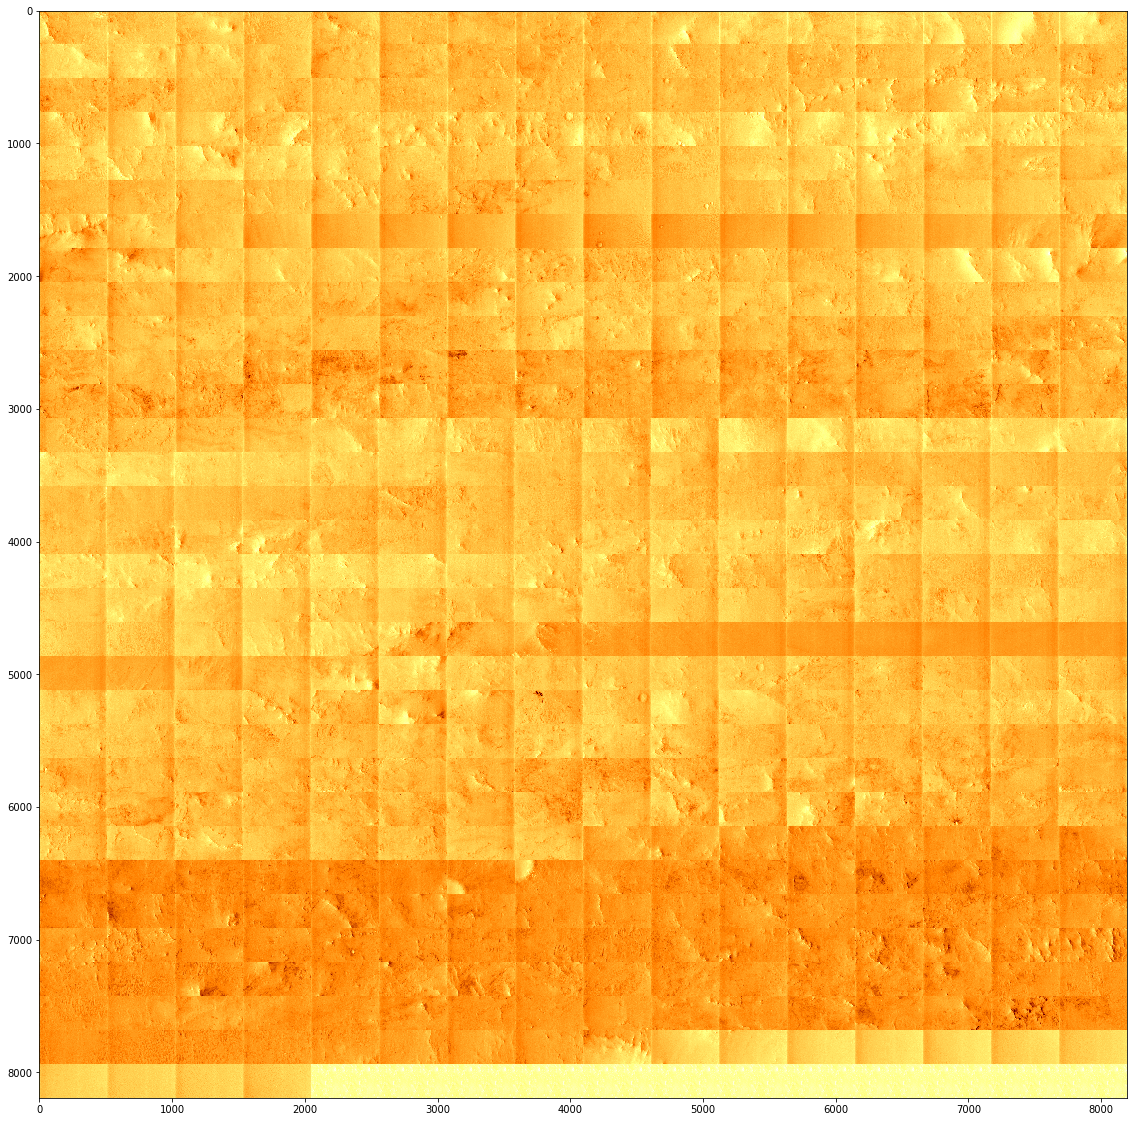

In [31]:
fit, ax = plt.subplots(figsize=(20, 20))
ax.imshow(sprite_image, cmap='afmhot');

#### create metadata

In [32]:
# write to metadata file names our patches
metadata_file = open(os.path.join(LOG_DIR, 'metadata_images.tsv'), 'w')

for i in range(num_images):
    metadata_file.write("{}\n".format(ids[i]))
metadata_file.close()

In [33]:
# get our embeddings from autoencoder and transform with TSNE
# input data must be NxHxWxC
tensor_images = numpy_images_to_tensor_dataset(images)
tensor_images = tensor_images / 255

embeddings = predict(tensor_images)

In [34]:
features = tf.Variable(embeddings, name='features');

In [35]:
with tf.Session() as sess:
    saver = tf.train.Saver([features])

    sess.run(features.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'names_images.ckpt'))
    
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = features.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = os.path.join(LOG_DIR, 'metadata_images.tsv')
    # Comment out if you don't want sprites
    embedding.sprite.image_path = os.path.join(LOG_DIR, '11000.png')
    embedding.sprite.single_image_dim.extend([256, 256])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)